# Assignment 2: Evaluating and Extending an RNN based Part-of-Speech Tagger
 
*version 2022.2, details/bugs might be fixed within the first week of publication, you will be notified if this happens*
 
When solving a new problem (or an old problem on a new data set), there are often some "shoulders of giants" to stand on. The first step is to look at the some good papers and try to download someone's code for solving a similar problem to the one you are faced with. The challenge is as much about understanding and adapting already existing code as it is about theoretical knowledge and creativity.
 
For this assignment, you start with a working pipeline for PoS tagging using LSTMs and mini-batch training. Your task is to evaluate the model on a number of sources in different languages. The neural model represents the data's tokens as non-pretrained embedding vectors. The sequences of embedding vectors are passed through a LSTM layer. The outputs from the recurrent layer are then transformed to probabilities over PoS tags by passing them through a fully connected layer and a softmax. You will have to refactor (i.e. rearrange the code) and extend the model by adding some commonly used properties, e.g. the RNN layer type or regularization (see the list of suggestions below).
 
The familiar Brown corpus is used for the reference implementation. This corpus should not be used in your submission.

## Submission
 
Please submit your code as a notebook through studium. You should include the following:
 
1. A working implementation of your pipeline, reproducing your principal results when run. Please ensure that outputs are stored in the notebook (preferably by rerunning your notebook as the last thing you do before submitting).
2. Comment the code properly, especially for longer or opaque functionality. Please try to write self documenting code (e.g. by choosing descriptive variables names, refactoring to isolate functionality, and by minimizing code duplication). This will also help you debug your code.
4. Comments on what you thought was hard in the assignment, what you think was educational, what took most time, and which parts might be unnecessarily tricky.
5. As the submission is anonymous, **all personal information must be removed**.
6. Apart from sections and titles, please remove all unnecessary text and code from the notebook you hand in (e.g., this instuction). Keep only that which strengthens the case that you fulfil the listed requirements.


## Requirements for grade G

To achieve a pass (G) on this assignment, you must solve the following tasks without serious errors.

1. Extend the given model in at least three of the ways listed in the *extensions* section. State clearly which ones you have implemented.
2. Include a short (250-500 words) qualitative analysis in your submission. Discuss the performance difference between languages/genres and design choices. You can spread this in the notebook or put them in one place.
3. Refactor the given model as a class (including relevant preprocessing, forward/backward pass etc). Your model class should follow the sklearn API where possible.
4. Not all languages require the same model complexity for PoS tagging. Some might need a higher dimensionality for the embedding or layers for the model to perform well. Briefly explore the relation between model complexity and accuracy? (Note that the goal is to examine model properties, not to get state-of-the-art accuracy)
5. In your quantitative evaluation, use some genre of text in three languages from the [universal dependencies](https://universaldependencies.org/) project (UD). These will be in the familiar `.conllu` format. Parse the files to get the words (not lemmas).
6. Network accuracy for one model doesn't say much about how well a model performs. Define a baseline accuracy and compare your results to it.
7. The training and testing data must be kept separate. As such, you should find some way of handling out-of-vocabulary words (OOV).


### Additional requirements for grade VG

For a pass with distinction grade (VG), you should extend your analysis to include all the items under *extensions*. State clearly which ones you have done.


### Extensions 
 
1. There are other types of RNNs layers commonly used in NLP. Add the option to use a GRU layer instead of LSTM, and include this in your performance comparison.
2. The given implementation only allows for dependencies from left to right. Add the option to use a bi-directional RNN layer.
3. Use pyTorch's `Dataset` and `DataLoader` classes for loading the data. [This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) is a good starting point. This should make it easier to loop over data sets.
4. Try some type of data augmentation in your training data (e.g. masking random tokens). This should theoretically increase the generalizability of your model. How much augmentation is too much?
5. Implement some level of regularization in your model. This can be implemented in several ways, e.g. dropout or weight decay. Briefly argue for the choices you made and show how network preformance might change with the rate of regularization.
6. Add more sources. You can both add sources with different genres and/or more languages. A suggestion is to try how languages with very different levels of morphological richness (e.g. English vs Finish) requires more or less training data. The total number of sources should be above 10.
7. Comment on shortcomings and how to improve the model in relation to a recent POS tagging paper (a good starting point for searching is [NLP-progress](http://nlpprogress.com/).
10. Compare performace using UD's universal vs language specific tag sets.

*Note that trying all combinations of the extensions is not required. It is enough to do some structured testing of extensions and then, for example, go on to compare the tag sets on the best model configuration. This is an exercise in extending and evaluating a model, not in finding the patience to wait for your computer to finish grid searching over alternatives.*


## General advice

Work from the given code and change one piece at a time, ensuring functionality throughout your work. You should test your code every couple of lines to make sure your assumptions on functionality and variable content are correct. A good rule of thumb is that a coder will introduce a bug every five lines (even as a professional).

To make sure your code does what it's supposed to do, use ```assert``` statements to check your assumptions. Keep the given asserts if you need them. Professional coders sometimes start with writing tests for some functionality instead of starting with the functionality itself. This is called *test-driven development*.

Finally, remember the great motto **RTFM**. It will save you in the future.


## Plagiarism
 
In code assignments, plagiarism is a tricky concept. A clean cut way would be to demand that you write all the code yourself, from memory, with only the assigned literature as help. This is not how code is developed professionally. It is common to copy and share. However, since this is a learning exercise, you must implement everything on your own, but please look at the course repo, Stack Overflow etc. Moreover, discuss with course mates and TAs to find inspiration and solutions. Code that is *obviously* copied (with minor modifications) will be considered as plagiarized. As a part of the examination, you might be asked to explain any particular part of the functionality in your implementation.

In [1]:
# Our standard imports for maths and basic methodology
import numpy as np
from sklearn.model_selection import train_test_split

# For user feedback
from tqdm import tqdm
import matplotlib.pyplot as plt

# Imports for pytorch
import torch
import torch.nn as nn

Let's see if we have a GPU.

In [2]:
if torch.cuda.is_available():
  for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
  print("No GPU available")

Tesla K80


## Load tagging data

The following downloads the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). This data is only here to demonstrate the network below.

In [3]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
nltk.download('universal_tagset')

sentences = brown.tagged_sents(tagset='universal')                        # Load the data
sentences = [sentence for sentence in sentences if len(sentence) > 2]     # Remove very short sentences

print("Loaded %i sentences" % len(sentences))
print(sentences[0])

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
Loaded 56283 sentences
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]


Preprocessing for the brow corpus. This splits the data into our standard X and y format.

In [4]:
X = [[token for token, tag in sentence] for sentence in sentences]
y = [[tag for token, tag in sentence] for sentence in sentences]

assert len(X) == len(y)

print(X[0])
print(y[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)
assert len(X_train)+len(X_test) == len(X)

print("The training set includes %i sentences" % len(X_train))
print("The test set includes %i sentences" % len(X_test))

The training set includes 50654 sentences
The test set includes 5629 sentences


Most sentences are short, but some are very long.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


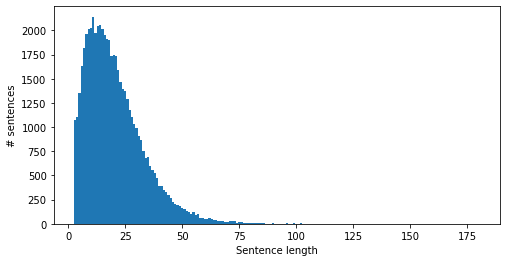

In [6]:
l = np.asarray([len(x) for x in X], dtype=np.int)
plt.figure(figsize=(8, 4))
x = np.unique(l)
plt.bar(x, [np.sum(l==e) for e in x], width=1)
plt.xlabel("Sentence length")
plt.ylabel("# sentences")
plt.show()

## Data encoding and padding

In [7]:
tokens = {token for sentence in X_train for token in sentence}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')
idx2token.append('<PAD>')
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for tags in y_train for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

print(idx2token[:15])
print(idx2tag)

['<UNK>', 'railway-based', 'Peugeot', 'anemic', 'flat-topped', 'Kayabashi', 'Pittsburgh', 'pangs', 'Seaman', 'jejunum', 'sags', 'sentinels', 'imagnation', 'Spuyten', 'inscribed']
['VERB', 'NOUN', 'ADJ', 'CONJ', 'X', 'ADP', 'DET', 'PRT', 'NUM', 'PRON', '.', 'ADV', '<PAD>']


In [8]:
def pad_and_encode(sentences, labels):
  assert len(sentences)==len(labels)
  assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
  max_sentence_length = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
  padded_sentences = torch.zeros(len(sentences), max_sentence_length,     # Create data structures with <PAD> as default
                                 dtype=torch.long)
  padded_sentences[:] = token2idx['<PAD>']
  padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                              dtype=torch.long)
  padded_labels[:] = tag2idx['<PAD>']
  for i, (sentence, tags) in enumerate(zip(sentences, labels)):               # Loop over the data
    for j, token in enumerate(sentence):
      if token in token2idx.keys():
        padded_sentences[i, j] = token2idx[token]
      else:
        padded_sentences[i, j] = token2idx['<UNK>']
    for j, tag in enumerate(tags):
      padded_labels[i, j] = tag2idx[tag]
  return padded_sentences, padded_labels

a, b = pad_and_encode(X_train[:5], y_train[:5])
print(a)
print(b)

tensor([[26104, 28759, 51279, 52437,  9625, 26778,  7129, 33772, 11063, 50428,
          7129, 33772,  4236,  7129, 34743, 16788, 19654, 53337, 53337, 53337,
         53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
        [39910, 16901, 49967,   672, 30878, 14090, 27806, 11784, 39522,  6291,
         32355, 37769, 49967,  1019, 29387, 47879, 27806, 29531, 39522, 12935,
         38518,  8426, 28615, 44010, 46465,  7129, 47879,  7992, 19654],
        [ 7740, 49969, 49556, 24115,  1019, 47770, 23315, 49967, 41297, 49743,
         41297,  7740, 14428, 24062, 19654, 53337, 53337, 53337, 53337, 53337,
         53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
        [14692, 32594,  2376, 34215,  1019, 42443, 32594,  2376, 42828, 19654,
         53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337,
         53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
        [42507,  7804, 33772, 42808, 49967,  7804, 33772, 11195, 49967, 5227

In [9]:
def batch_iterator(sentences, labels, batch_size=64):
  """Helper function for iterating over batches of the data"""
  assert len(sentences) == len(labels)
  for i in range(0, len(sentences), batch_size):
    X, y = pad_and_encode(sentences[i:min(i+batch_size, len(sentences))], 
                          labels[i:min(i+batch_size, len(sentences))])
    if torch.cuda.is_available():                                               # Move data to the GPU, if possible, before yielding it
      yield (X.cuda(), y.cuda())
    else:
      yield (X, y)

next(batch_iterator(X_train, y_train, batch_size=5))

(tensor([[26104, 28759, 51279, 52437,  9625, 26778,  7129, 33772, 11063, 50428,
           7129, 33772,  4236,  7129, 34743, 16788, 19654, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [39910, 16901, 49967,   672, 30878, 14090, 27806, 11784, 39522,  6291,
          32355, 37769, 49967,  1019, 29387, 47879, 27806, 29531, 39522, 12935,
          38518,  8426, 28615, 44010, 46465,  7129, 47879,  7992, 19654],
         [ 7740, 49969, 49556, 24115,  1019, 47770, 23315, 49967, 41297, 49743,
          41297,  7740, 14428, 24062, 19654, 53337, 53337, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [14692, 32594,  2376, 34215,  1019, 42443, 32594,  2376, 42828, 19654,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337,
          53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337, 53337],
         [42507,  7804, 33772, 42808, 49967,  7804, 33772, 11195

## Model

In [10]:
class LSTMTagger(nn.Module):
  def __init__(self, word_embedding_dim, lstm_hidden_dim, vocabulary_size, tagset_size):
    """An LSTM based tagger
    
    word_embedding_dim
      The dimensionality of the word embedding
    lstm_hidden_dim
      The dimensionality of the hidden state in the LSTM
    vocabulary_size
      The number of unique tokens in the word embedding (including <PAD> etc)
    tagset_size
      The number of unique POS tags (not including <PAD>, as we don't want to predict it)
    """
    super(LSTMTagger, self).__init__()                                          # We need to initialise the class we are inheriting from
    self.lstm_hidden_dim_ = lstm_hidden_dim                                     # This simply stores the parameters
    self.vocabulary_size_ = vocabulary_size
    self.tagset_size_ = tagset_size

    self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,         # Creates the vector space for the input words
                                         embedding_dim=word_embedding_dim, 
                                         padding_idx=token2idx['<PAD>'])
    self._lstm = nn.LSTM(input_size=word_embedding_dim,                         # The LSTM takes an embedded sentence as input, and outputs 
                         hidden_size=lstm_hidden_dim,                           # vectors with dimensionality lstm_hidden_dim.
                         batch_first=True)
    self._fc = nn.Linear(lstm_hidden_dim, tagset_size)                          # The linear layer maps from the RNN output space to tag space
    self._softmax = nn.LogSoftmax(dim=1)                                        # Softmax of outputting PDFs over tags
    
    self.training_loss_ = list()                                                # For plotting
    self.training_accuracy_ = list()

    if torch.cuda.is_available():                                               # Move the model to the GPU (if we have one)
      self.cuda()

  def forward(self, padded_sentences):
    """The forward pass through the network"""
    batch_size, max_sentence_length = padded_sentences.size()

    embedded_sentences = self._word_embedding(padded_sentences)                 # Sentences encoded as integers are mapped to vectors    

    sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)        # Find the length of sentences
    sentence_lengths = sentence_lengths.long().cpu()                            # Ensure the correct format
    X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths, # Pack the embedded data
                                          batch_first=True, enforce_sorted=False)
    lstm_out, _ = self._lstm(X)                                                 # Run the LSTM layer
    X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)         # Unpack the output from the LSTM

    X = X.contiguous().view(-1, X.shape[2])                                     # The output from the LSTM layer is flattened
    tag_space = self._fc(X)                                                     # Fully connected layer
    tag_scores = self._softmax(tag_space)                                       # Softmax is applied to normalise the outputs
    return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)


model = LSTMTagger(word_embedding_dim=32,                                       # Dimensionality of the work embedding
                   lstm_hidden_dim=64,                                          # Dimensionality of the hidden state in the LSTM
                   vocabulary_size=len(token2idx),                              # The vocabulary incudes both the 'padding' and 'unknown' symbols
                   tagset_size=len(tag2idx)-1)                                  # We have no interest in the network outputting the padding symbol
print(model)

LSTMTagger(
  (_word_embedding): Embedding(53338, 32, padding_idx=53337)
  (_lstm): LSTM(32, 64, batch_first=True)
  (_fc): Linear(in_features=64, out_features=12, bias=True)
  (_softmax): LogSoftmax(dim=1)
)


## Network training

In [11]:
loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])                       # A loss function that fits our choice of output layer and data. The
                                                                                # loss function will ignore the padding index in the targets.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)                                # We give the optimiser the parameters to work with, note that we can choose to only give some parameters

batch_size = 256                                                                # Define the size of each batch
for epoch in range(5):                                                          # Times to loop over the full dataset
  with tqdm(batch_iterator(X_train, y_train, batch_size=batch_size), 
            total=len(X_train)//batch_size+1, unit="batch", desc="Epoch %i" % epoch) as batches:
    for inputs, targets in batches:                                             # Loop once over the training data
      model.zero_grad()                                                         # Reset gradients
      scores = model(inputs)                                                    # Forward pass
      loss = loss_function(scores.view(-1, model.tagset_size_),                 # Get loss, the data is reshaped as a long line of predictions and targets
                           targets.view(-1))               
      loss.backward()                                                           # Backpropagate the error
      optimizer.step()                                                          # Run the optimizer to change the weights w.r.t the loss
      predictions = scores.argmax(dim=2, keepdim=True).squeeze()                # Calculate the batch training accuracy
      mask = targets!=tag2idx['<PAD>']                                          # Create a mask for ignoring <PAD> in the targets
      correct = (predictions[mask] == targets[mask]).sum().item()               # Item pulls the value from the GPU automatically (if needed)
      accuracy = correct / mask.sum().item()*100
      model.training_accuracy_.append(accuracy)                                 # Save the accuracy for plotting
      model.training_loss_.append(loss.item())                                  # Save the loss for plotting
      batches.set_postfix(loss=loss.item(), accuracy=accuracy)                  # Update the progress bar

Epoch 4: 100%|██████████| 198/198 [00:19<00:00, 10.07batch/s, accuracy=98, loss=0.0537]


We can plot the stored loss over epochs.

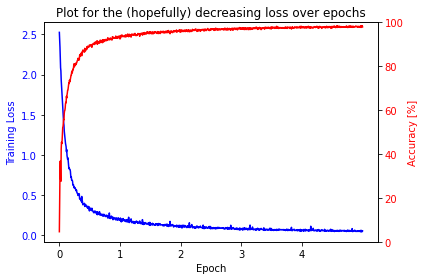

In [12]:
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot()
ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
ax.plot(model.training_loss_, 'b-')
ax.set_ylabel("Training Loss", color='b')
ax.set_xlabel("Epoch")
# ax.set_yscale('log')
ax.tick_params(axis='y', labelcolor='b')
ax = ax.twinx()
ax.plot(model.training_accuracy_, 'r-')
ax.set_ylabel("Accuracy [%]", color='r')
ax.tick_params(axis='y', labelcolor='r')
a = list(ax.axis())
a[2] = 0
a[3] = 100
ax.axis(a)
t = np.arange(0, len(model.training_accuracy_), len(X_train)//batch_size+1)
ax.set_xticks(ticks=t)
ax.set_xticklabels(labels=np.arange(len(t)))
fig.tight_layout()
plt.show()

## Test data accuracy

This shows that the model sort of works. A per sentence accuracy would be better while being able to also analyse the predictions qualitatively would be best.

In [13]:
with torch.no_grad():                                                           # Do not use the following forward passes to calculate a gradient
  n_correct = 0
  n_total = 0
  for inputs, targets in batch_iterator(X_test, y_test, batch_size=batch_size): # Loop once over the test data
    scores = model(inputs)                                                      # Runs the test data through the model
    predictions = scores.argmax(dim=2, keepdim=True).squeeze()                  # Finds the predictions
    mask = targets!=tag2idx['<PAD>']                                            # Create a mask for ignoring <PAD> in the targets
    n_correct += (predictions[mask] == targets[mask]).sum().item()              # Sums the number of correct predictions
    n_total += mask.sum().item()
print("Test accuracy %.1f%%" % (100*n_correct/n_total))

Test accuracy 95.8%
